### **Extracción de ragos**

- Alumno: Álvaro Santana Sánchez
- Fecha: Diciembre-2024

Las imagenes del dataset deben tener esta organización de carpetas desde el directorio raíz:

- PATH_POSITIVE_TRAIN = "kmnist\\train\\3\\"
- PATH_NEGATIVE_TRAIN = "kmnist\\train\\7\\"
- PATH_POSITIVE_TEST = "kmnist\\test\\3\\"
- PATH_NEGATIVE_TEST = "kmnist\\test\\7\\"
- IMAGE_EXTENSION = ".png"


In [1]:
#Importanción de datos

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from utils import *
from descriptores import LBPDescriptor, HogDescriptor
from LBPUDescriptor import LBPUDescriptor
from utils import transform_array_to_img
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier

100%|██████████| 6000/6000 [00:00<00:00, 14879.51it/s]


Leidas  6000 imágenes de entrenamiento -> positivas


100%|██████████| 6000/6000 [00:00<00:00, 17752.75it/s]


Leidas  6000 imágenes de entrenamiento -> negativas


100%|██████████| 1000/1000 [00:00<00:00, 17856.54it/s]


Leidas  1000 imágenes de test -> positivas


100%|██████████| 1000/1000 [00:00<00:00, 18182.11it/s]


Leidas  1000 imágenes de test -> negativas
(28, 28)


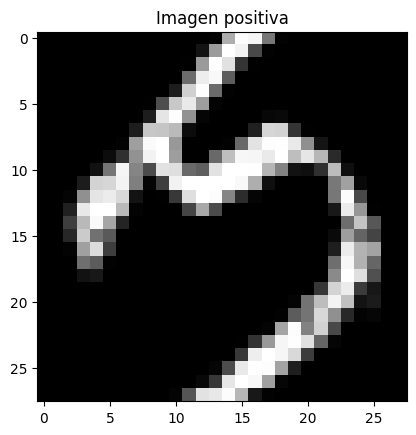

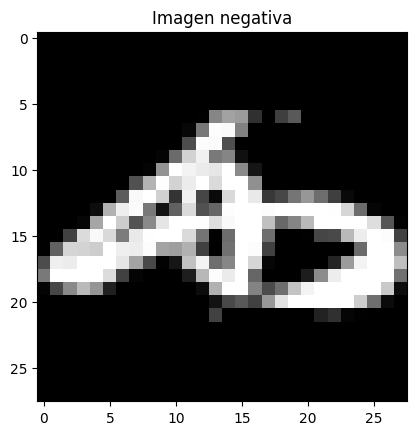

In [2]:
#Carga de imágenes
X_images, X_labels = cargar_imagenes()
y_images, y_labels = cargar_imagenes(test=True)

zero_class_example_index = np.where(X_labels == 0)[0][0]
one_class_example_index = np.where(X_labels == 1)[0][0]
plt.figure()
plt.title("Imagen positiva")
plt.imshow(X_images[one_class_example_index],cmap='gray')

plt.figure()
plt.title("Imagen negativa")
plt.imshow(X_images[zero_class_example_index],cmap='gray')

print(X_images[0].shape)

In [3]:
#Imagen para pruebas que usaremos en LBP y LBPU
imagen_artificial = np.array([[ 41, 218 ,216, 216 ,  8 , 65  ,90 ,172 ,233],
                              [224 ,103 , 143 , 99  ,35 , 87 ,235 , 11 ,198],
                              [117 ,217 ,201 , 19 ,154 , 56 ,149 ,124 ,  5],
                              [178 ,245 ,106 ,182 ,220 , 61  , 6 ,183 ,129],
                              [ 82  ,73  ,76 , 15  ,59 ,196 ,175 ,134 ,165],
                              [ 73 ,104 ,102 ,215 ,136 ,201 ,250 , 60 , 29],
                              [244 ,235 ,106 , 61  ,24 ,217 ,170 ,200 ,128],
                              [ 53  , 4 ,114 , 18 ,241 ,207 ,158 ,108 , 48],
                              [168  ,30 , 10 , 89 ,182 ,229 ,241  ,48 , 63]])


### **HOG**

In [4]:
#Inicialización de descriptores
hog = HogDescriptor()
X_hog_descriptors = compute_image_descriptors(X_images, descriptor_model=hog)


Computando descriptores


100%|██████████| 12000/12000 [00:00<00:00, 25884.04it/s]


In [5]:
X_hog_descriptors.shape

(12000, 4356)

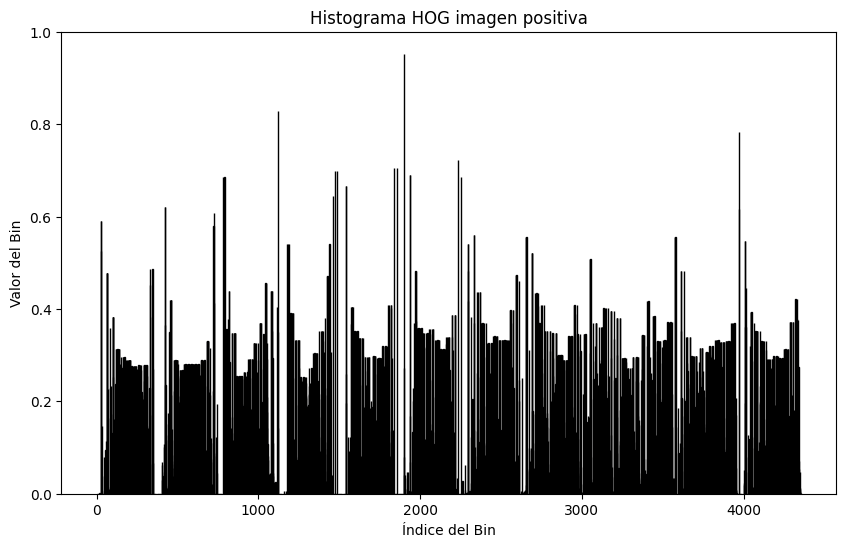

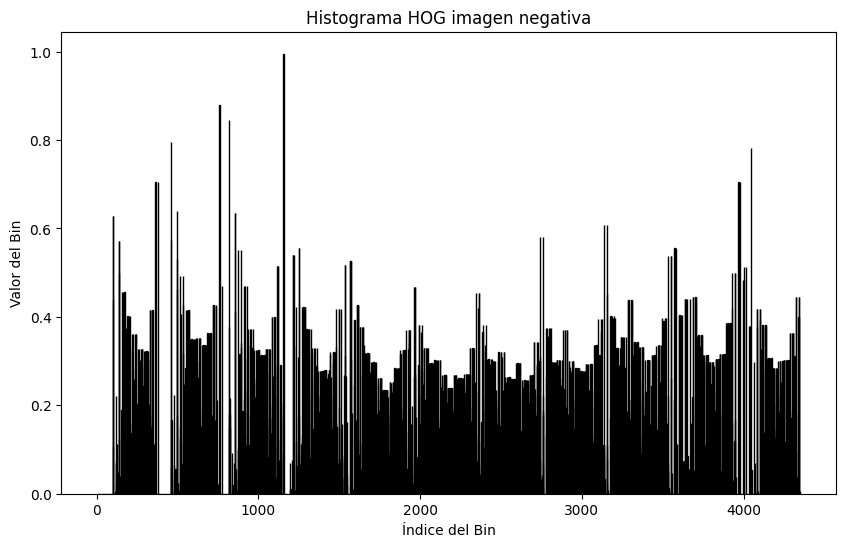

In [6]:
#Ejemplo histograma
print_descriptor_histogram(hog.compute(X_images[one_class_example_index]),title='Histograma HOG imagen positiva')

print_descriptor_histogram(hog.compute(X_images[zero_class_example_index]),title='Histograma HOG imagen negativa')


### **Búsqueda de hiperparámetros**

Esta parte no se ejecutará a no ser que se borren los resultados de cada GridSearch.

In [7]:

best_first_comparation = {'C': 1, 'kernel': 'poly'}
if not best_first_comparation:
    parameters = {'kernel':['linear','poly'], 'C':[0.1,1,5,15]}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters,scoring='accuracy',return_train_score=True,verbose=2)
    clf.fit(X_hog_descriptors,X_labels)
    best_first_comparation = clf.best_params_


In [8]:
best_rbf_parameter = {'C': 5, 'gamma': 0.01}
if not best_rbf_parameter:
    parameters = {'C':[0.1,1,5,15],
                  'gamma': [1, 0.1, 0.01, 0.001]}
    svc = svm.SVC(kernel='rbf')
    clf_rbf = GridSearchCV(svc, parameters,scoring='accuracy',return_train_score=True,verbose=2,cv=3,n_jobs=-1)
    clf_rbf.fit(X_hog_descriptors[0::2],X_labels[0::2])
    best_rbf_parameter = clf_rbf.best_params_

In [9]:
best ={'C': 1, 'kernel': 'poly'} 
if not best:
    final_parameters = {'kernel':['rbf','poly'], 'C':[1,5]}
    svc = svm.SVC(gamma=0.01)
    clf_final = GridSearchCV(svc, final_parameters,scoring='accuracy',return_train_score=True,verbose=2,cv=3,n_jobs=-1)
    clf_final.fit(X_hog_descriptors,X_labels)
    best = clf_final.best_params_
best


{'C': 1, 'kernel': 'poly'}

### **Entrenamiento del modelo**

In [10]:
svm_clf_hog = svm.SVC(kernel='poly', C=1)
svm_clf_hog.fit(X_hog_descriptors, X_labels)

SVC(C=1, kernel='poly')

### **Evaluación mediante test**

In [11]:
y_hog_descriptors = compute_image_descriptors(y_images, descriptor_model=hog)
svm_hog_predictions = svm_clf_hog.predict(y_hog_descriptors)

accuracy = accuracy_score(y_labels, svm_hog_predictions)
precision = precision_score(y_labels, svm_hog_predictions)
recall = recall_score(y_labels, svm_hog_predictions)
f1 = f1_score(y_labels, svm_hog_predictions)
confusion_matrix_value = confusion_matrix(y_labels, svm_hog_predictions)

print("accuracy:",accuracy)
print("Precision:",precision)
print("recall:",recall),
print("f1:",f1)
print("confusion_matrix:",confusion_matrix_value)

Computando descriptores


100%|██████████| 2000/2000 [00:00<00:00, 24995.63it/s]


accuracy: 0.9985
Precision: 1.0
recall: 0.997
f1: 0.9984977466199298
confusion_matrix: [[1000    0]
 [   3  997]]


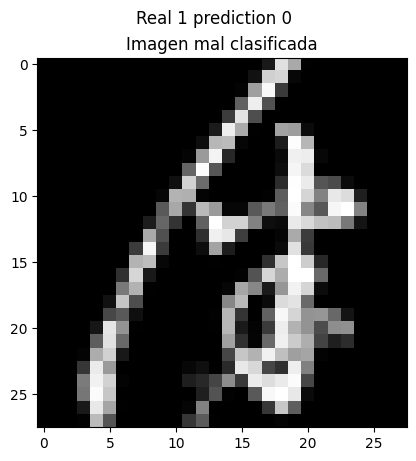

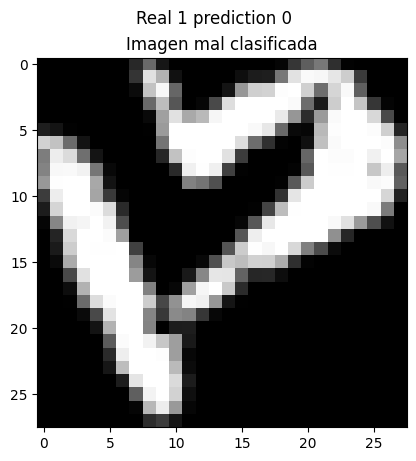

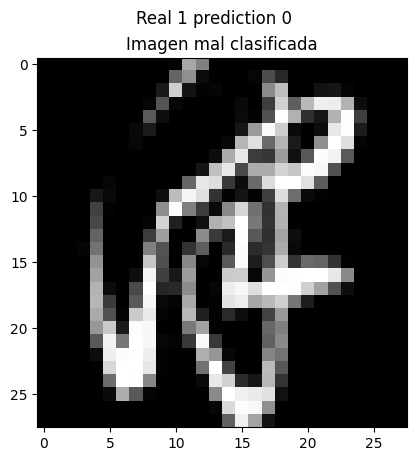

In [12]:
bad_classificated_indexs = np.where(y_labels != svm_hog_predictions)[0]

for index in bad_classificated_indexs:
    plt.figure()
    plt.title(f"Imagen mal clasificada")
    plt.suptitle(f"Real {y_labels[index]} prediction {svm_hog_predictions[index]}")
    plt.imshow(y_images[index],cmap='gray')

In [13]:
#Calculo de clasificacion de valores 
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_hog_descriptors, X_labels)
dummy_predictions = dummy_clf.predict(y_hog_descriptors)
print(dummy_predictions)

accuracy = accuracy_score(y_labels, dummy_predictions)
precision = precision_score(y_labels, dummy_predictions,zero_division=0)
recall = recall_score(y_labels, dummy_predictions)
f1 = f1_score(y_labels, dummy_predictions)
confusion_matrix_value = confusion_matrix(y_labels,dummy_predictions)

print("accuracy:",accuracy)
print("Precision:",precision)
print("recall:",recall),
print("f1:",f1)
print("confusion_matrix:",confusion_matrix_value)

[0 0 0 ... 0 0 0]
accuracy: 0.5
Precision: 0.0
recall: 0.0
f1: 0.0
confusion_matrix: [[1000    0]
 [1000    0]]


## **LBP**

In [14]:
#Computacion de valores LBP
lbp = LBPDescriptor()
X_lbp_descriptors = compute_image_descriptors(X_images, descriptor_model=lbp)

Computando descriptores


100%|██████████| 12000/12000 [00:38<00:00, 315.05it/s]


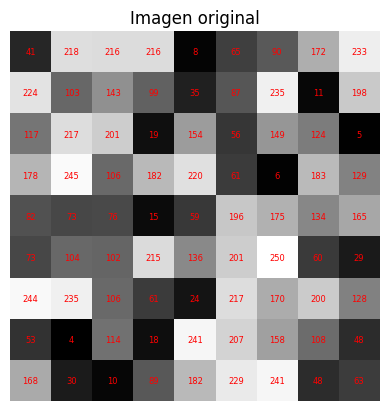

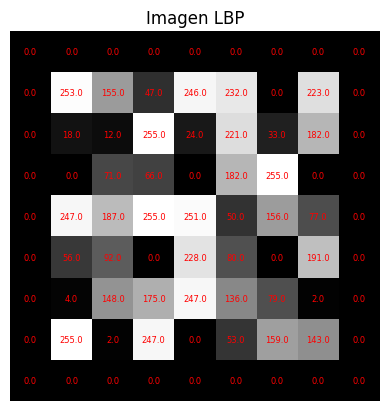

In [15]:
#Muestra de valores teóricos
for i in range(0, imagen_artificial.shape[0]):  #
    for j in range(0, imagen_artificial.shape[1]):
        pixel_value = imagen_artificial[i, j]
        plt.text(j, i, str(pixel_value), color='red', fontsize=6, ha='center', va='center')

plt.axis('off')
plt.title("Imagen original")
plt.imshow(imagen_artificial,cmap='gray')

plt.figure()

lbp_imagen_artificial =transform_array_to_img(lbp.compute_lbp_image(imagen_artificial))
for i in range(0, lbp_imagen_artificial.shape[0]):  
    for j in range(0, lbp_imagen_artificial.shape[0]):
        pixel_value = lbp_imagen_artificial[i, j]
        plt.text(j, i, str(pixel_value), color='red', fontsize=6, ha='center', va='center')

plt.axis('off')
plt.title("Imagen LBP")
plt.imshow(lbp_imagen_artificial,cmap='gray')

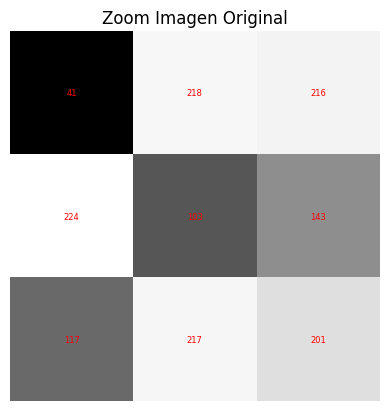

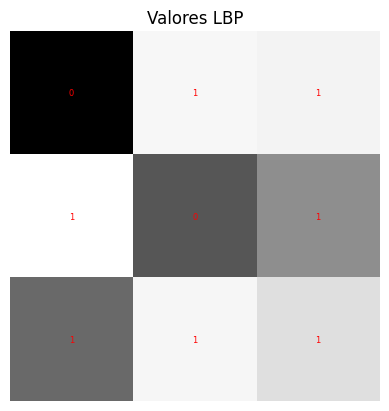

In [16]:
zoom_imagen_artificial = imagen_artificial[0:3,0:3]
for i in range(0,3):  
    for j in range(0,3):
        pixel_value = zoom_imagen_artificial[i, j]
        plt.text(j, i, str(pixel_value), color='red', fontsize=6, ha='center', va='center')

plt.axis('off')
plt.title("Zoom Imagen Original")
plt.imshow(zoom_imagen_artificial,cmap='gray')

plt.figure()
mayor_menor = np.array([1  if x > zoom_imagen_artificial[1,1] else 0 for x in zoom_imagen_artificial.flatten() ]).reshape(3,3)
for i in range(0,3):  
    for j in range(0,3):
        pixel_value = mayor_menor[i, j]
        plt.text(j, i, str(pixel_value), color='red', fontsize=6, ha='center', va='center')

plt.axis('off')
plt.title("Valores LBP")
plt.imshow(zoom_imagen_artificial,cmap='gray')


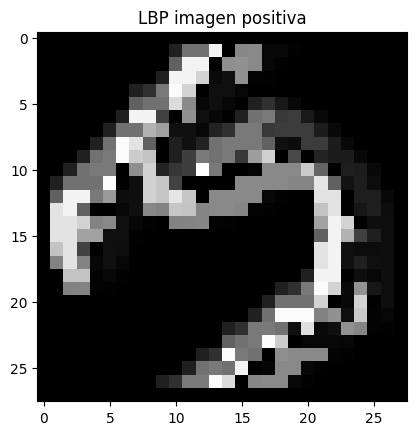

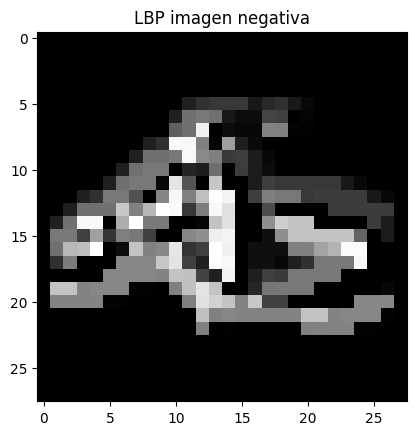

In [17]:
lbp = LBPDescriptor()
plt.figure()
plt.title("LBP imagen positiva")
plt.imshow(transform_array_to_img(lbp.compute_lbp_image(X_images[one_class_example_index])), cmap='gray')

plt.figure()
plt.title("LBP imagen negativa")
plt.imshow(transform_array_to_img(lbp.compute_lbp_image(X_images[zero_class_example_index])), cmap='gray')

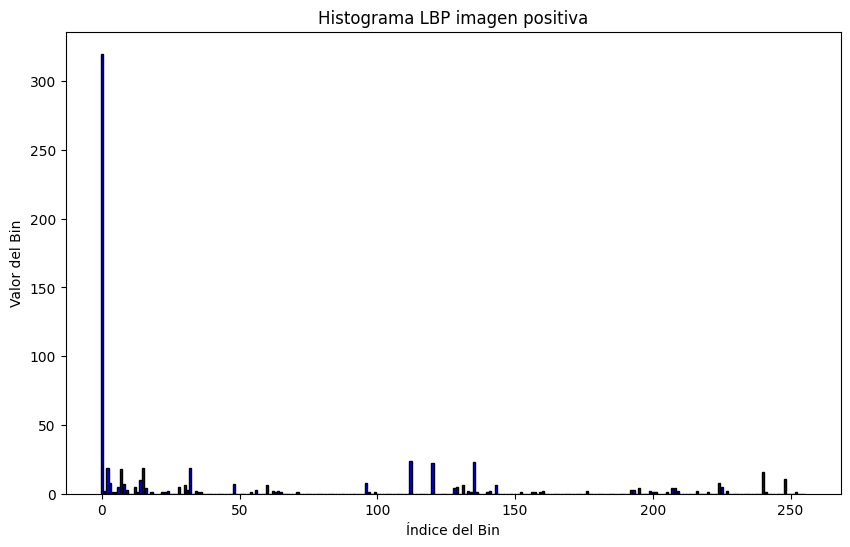

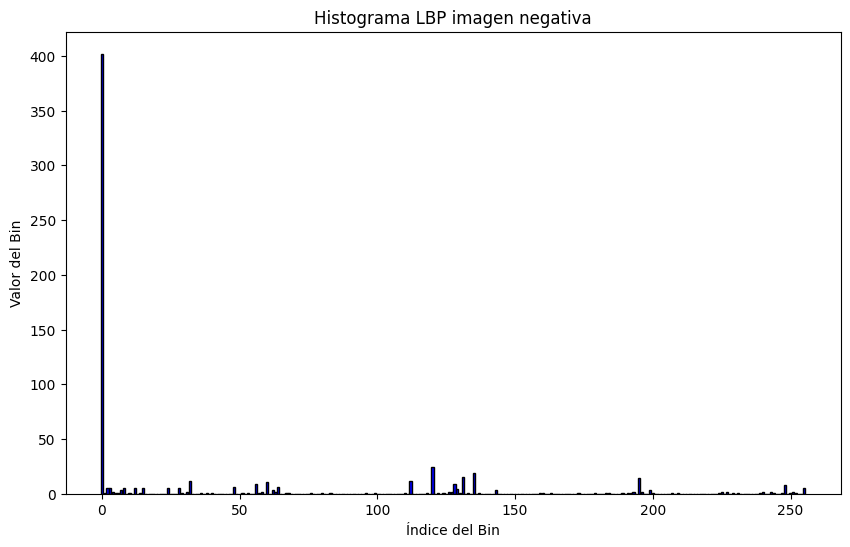

In [18]:
print_descriptor_histogram(lbp.compute(X_images[one_class_example_index]),title='Histograma LBP imagen positiva')

print_descriptor_histogram(lbp.compute(X_images[zero_class_example_index]),title='Histograma LBP imagen negativa')


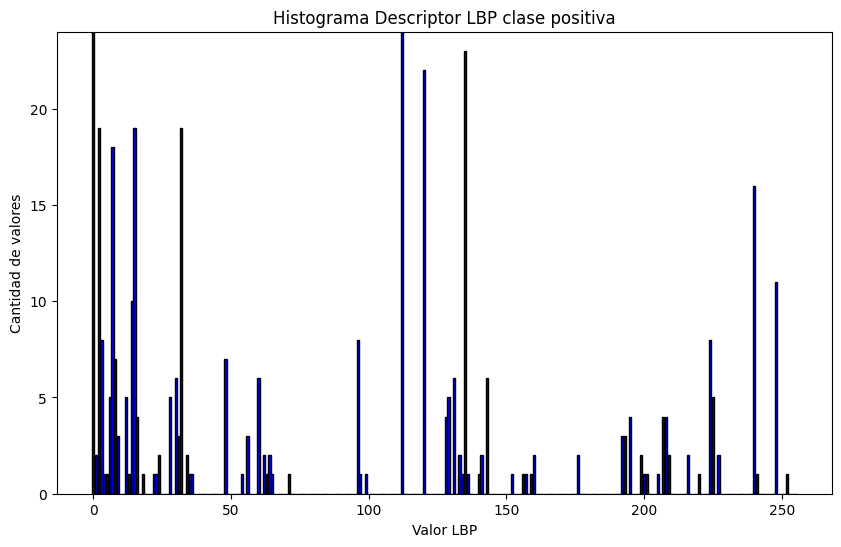

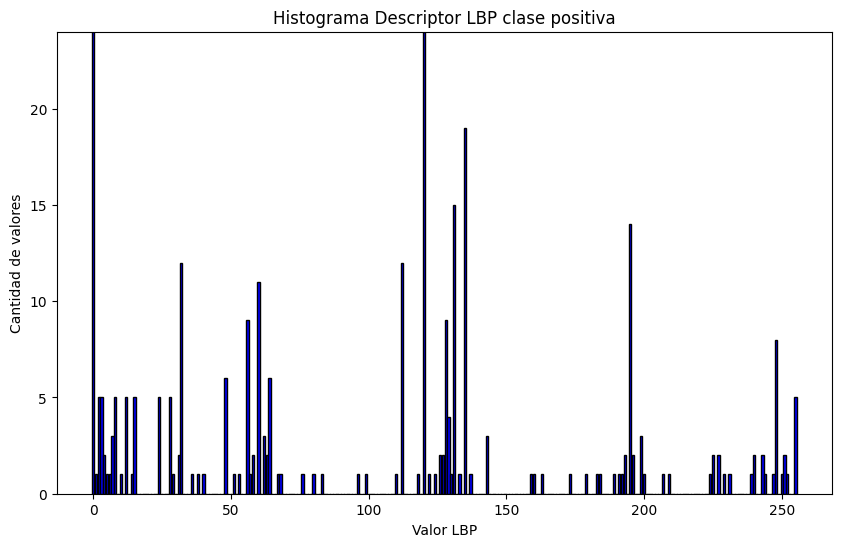

In [19]:
lbp_descriptor_one_class = lbp.compute(X_images[one_class_example_index])
print_descriptor_histogram2(lbp_descriptor_one_class,title="Histograma Descriptor LBP clase positiva",xlabel='Valor LBP')

lbp_descriptor_zero_class = lbp.compute(X_images[zero_class_example_index])
print_descriptor_histogram2(lbp_descriptor_zero_class,title="Histograma Descriptor LBP clase positiva",xlabel='Valor LBP')

### **Entrenamiento del modelo**

In [20]:
svm_clf_lbp = svm.SVC(kernel='poly', C=1)
svm_clf_lbp.fit(X_lbp_descriptors, X_labels)

SVC(C=1, kernel='poly')

### **Evaluación mediante test**

In [21]:
y_lbp_descriptors = compute_image_descriptors(y_images, descriptor_model=lbp)
svm_lbp_predictions = svm_clf_lbp.predict(y_lbp_descriptors)

accuracy = accuracy_score(y_labels, svm_lbp_predictions)
precision = precision_score(y_labels, svm_lbp_predictions)
recall = recall_score(y_labels, svm_lbp_predictions)
f1 = f1_score(y_labels, svm_lbp_predictions)
confusion_matrix_value = confusion_matrix(y_labels, svm_lbp_predictions)

print("accuracy:",accuracy)
print("Precision:",precision)
print("recall:",recall),
print("f1:",f1)
print("confusion_matrix:",confusion_matrix_value)

Computando descriptores


100%|██████████| 2000/2000 [00:06<00:00, 305.32it/s]


accuracy: 0.8695
Precision: 0.8349954669084315
recall: 0.921
f1: 0.8758915834522111
confusion_matrix: [[818 182]
 [ 79 921]]


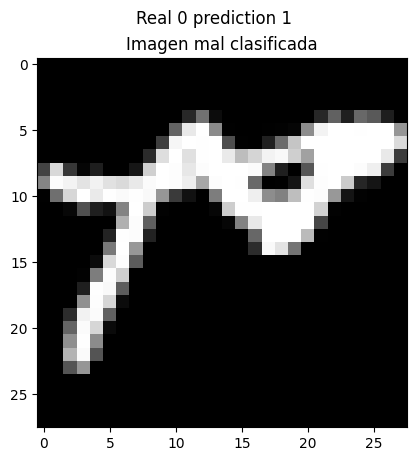

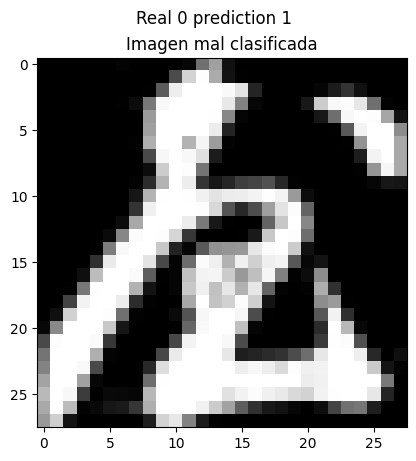

In [22]:
false_positive = np.where((y_labels != svm_lbp_predictions) & (y_labels == 0))[0]

for index in false_positive[0:2]:
    plt.figure()
    plt.title(f"Imagen mal clasificada")
    plt.suptitle(f"Real {y_labels[index]} prediction {svm_lbp_predictions[index]}")
    plt.imshow(y_images[index],cmap='gray')


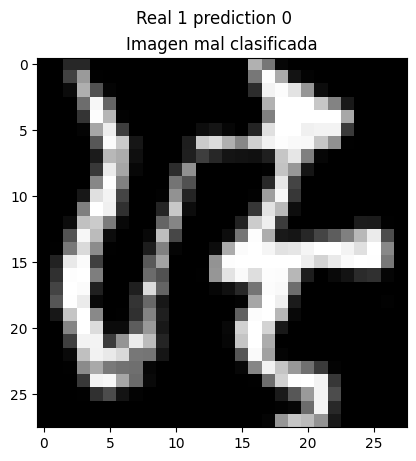

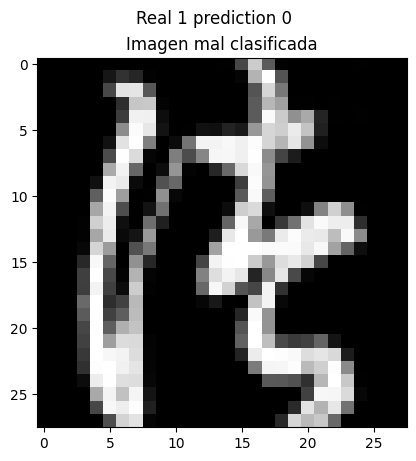

In [23]:
false_negative = np.where((y_labels != svm_lbp_predictions) & (y_labels == 1))[0]

for index in false_negative[0:2]:
    plt.figure()
    plt.title(f"Imagen mal clasificada")
    plt.suptitle(f"Real {y_labels[index]} prediction {svm_lbp_predictions[index]}")
    plt.imshow(y_images[index],cmap='gray')


### **LBP UNIFORME**

In [24]:
lbpu = LBPUDescriptor(window_size=3)
X_lbpu_descriptors = compute_image_descriptors(images=X_images,descriptor_model=lbpu)

Computando descriptores


100%|██████████| 12000/12000 [00:37<00:00, 318.69it/s]


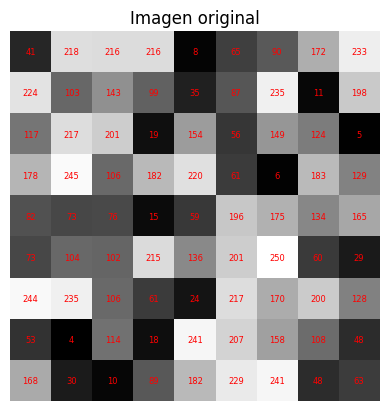

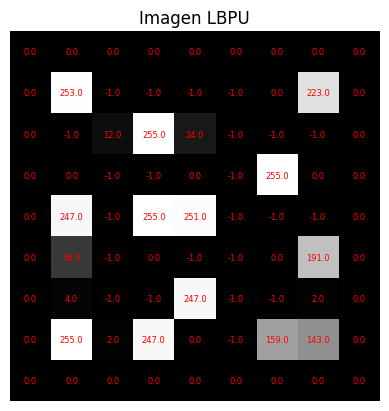

In [25]:
lbpu = LBPUDescriptor(window_size=3)
for i in range(0, imagen_artificial.shape[0]):  
    for j in range(0, imagen_artificial.shape[1]):
        pixel_value = imagen_artificial[i, j]
        plt.text(j, i, str(pixel_value), color='red', fontsize=6, ha='center', va='center')

plt.axis('off')
plt.title("Imagen original")
plt.imshow(imagen_artificial,cmap='gray')

plt.figure()

lbpu_imagen_artificial = transform_array_to_img(lbpu.compute_lbpu_image(imagen_artificial))
for i in range(0, lbpu_imagen_artificial.shape[0]):  
    for j in range(0, lbpu_imagen_artificial.shape[0]):
        pixel_value = lbpu_imagen_artificial[i, j]
        plt.text(j, i, str(pixel_value), color='red', fontsize=6, ha='center', va='center')

plt.axis('off')
plt.title("Imagen LBPU")
plt.imshow(lbpu_imagen_artificial,cmap='gray')

[array([82, 73, 76]), array([ 73, 104, 102]), array([244, 235, 106])]
56


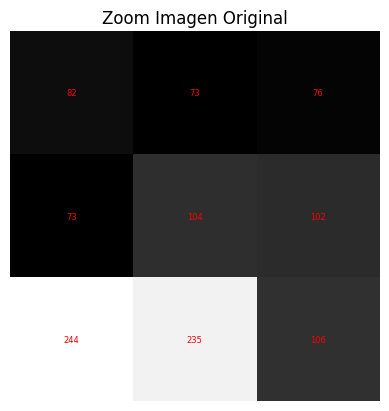

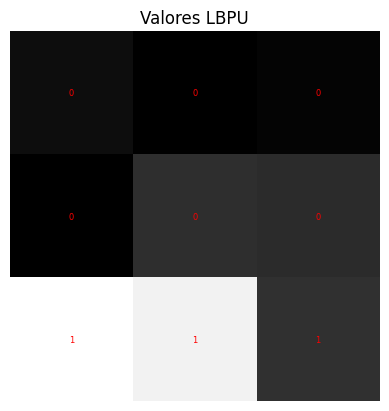

In [26]:
zoom_imagen_artificial = imagen_artificial[4:7,0:3]
for i in range(0,3):  
    for j in range(0,3):
        pixel_value = zoom_imagen_artificial[i, j]
        plt.text(j, i, str(pixel_value), color='red', fontsize=6, ha='center', va='center')

plt.axis('off')
plt.title("Zoom Imagen Original")
plt.imshow(zoom_imagen_artificial,cmap='gray')

plt.figure()
mayor_menor = np.array([1  if x > zoom_imagen_artificial[1,1] else 0 for x in zoom_imagen_artificial.flatten() ]).reshape(3,3)
for i in range(0,3):  
    for j in range(0,3):
        pixel_value = mayor_menor[i, j]
        plt.text(j, i, str(pixel_value), color='red', fontsize=6, ha='center', va='center')
        
        
print([a for a in zoom_imagen_artificial])
print(lbpu._uniform_neighborhood_comparation([a for a in zoom_imagen_artificial.flatten()],104))

plt.axis('off')
plt.title("Valores LBPU")
plt.imshow(zoom_imagen_artificial,cmap='gray')


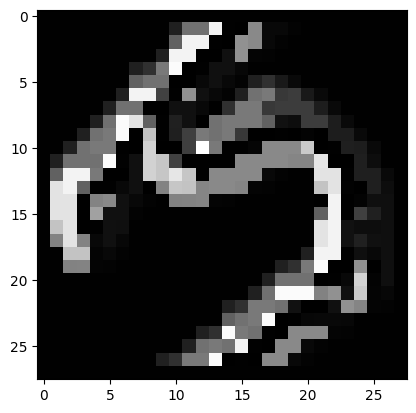

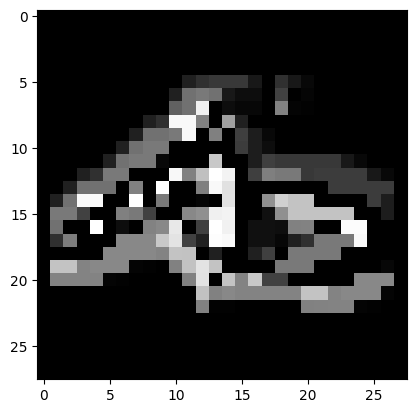

In [27]:

plt.figure()
plt.imshow(X=transform_array_to_img(lbpu.compute_lbpu_image(X_images[one_class_example_index])), cmap='gray')
plt.figure()
plt.imshow(X=transform_array_to_img(lbpu.compute_lbpu_image(X_images[zero_class_example_index])), cmap='gray')


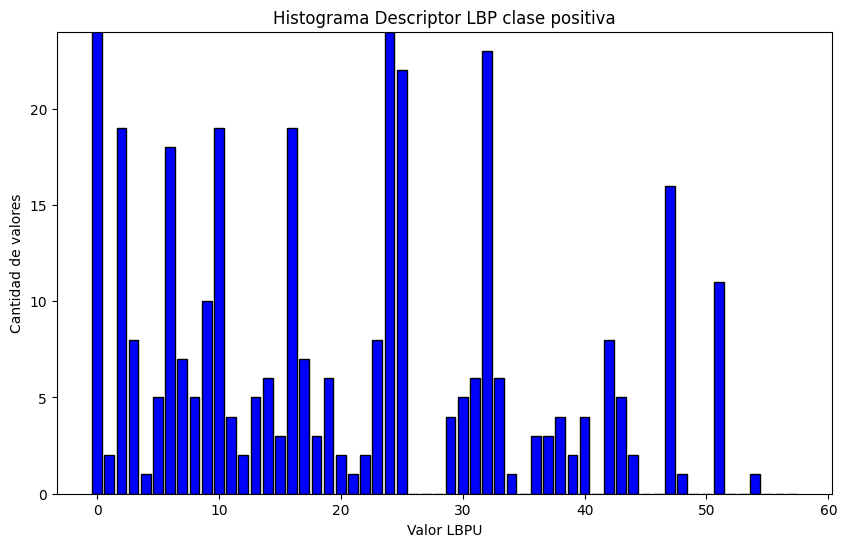

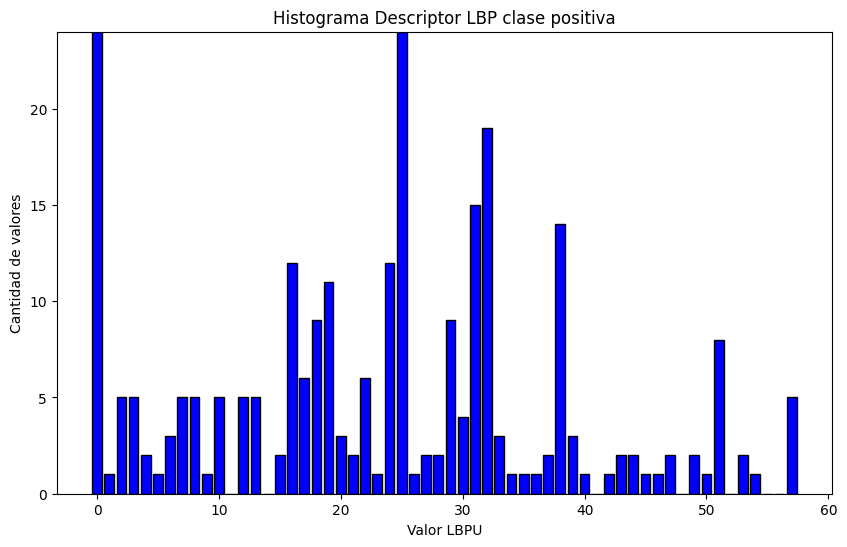

In [28]:

lbpu_descriptor_one_class = lbpu.compute(X_images[one_class_example_index])
print_descriptor_histogram2(lbpu_descriptor_one_class,title="Histograma Descriptor LBP clase positiva",xlabel='Valor LBPU')

lbpu_descriptor_zero_class = lbpu.compute(X_images[zero_class_example_index])
print_descriptor_histogram2(lbpu_descriptor_zero_class,title="Histograma Descriptor LBP clase positiva",xlabel='Valor LBPU')



### **Entrenamiento del modelo**


In [29]:
svm_clf_lbpu = svm.SVC(kernel='poly', C=1,probability=True)
svm_clf_lbpu.fit(X_lbpu_descriptors, X_labels)

SVC(C=1, kernel='poly', probability=True)


### **Evaluación mediante test**


In [30]:
y_lbpu_descriptors = compute_image_descriptors(y_images, descriptor_model=lbpu)
svm_lbpu_predictions = svm_clf_lbpu.predict(y_lbpu_descriptors)

accuracy = accuracy_score(y_labels, svm_lbpu_predictions)
precision = precision_score(y_labels, svm_lbpu_predictions)
recall = recall_score(y_labels, svm_lbpu_predictions)
f1 = f1_score(y_labels, svm_lbpu_predictions)
confusion_matrix_value = confusion_matrix(y_labels, svm_lbpu_predictions)

print("accuracy:",accuracy)
print("Precision:",precision)
print("recall:",recall),
print("f1:",f1)
print("confusion_matrix:",confusion_matrix_value)

Computando descriptores


100%|██████████| 2000/2000 [00:06<00:00, 310.70it/s]

accuracy: 0.863
Precision: 0.83
recall: 0.913
f1: 0.8695238095238095
confusion_matrix: [[813 187]
 [ 87 913]]


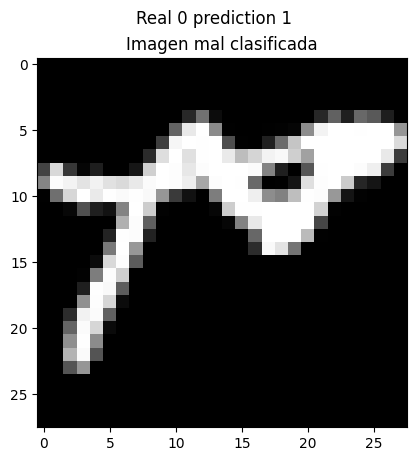

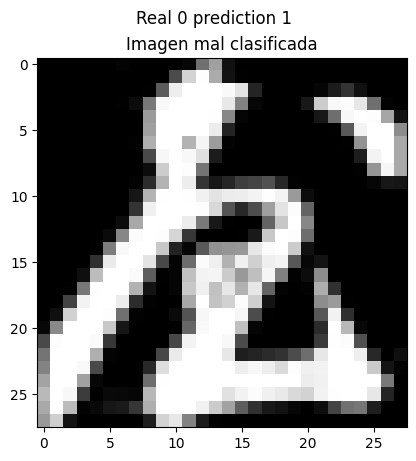

In [31]:
false_positive = np.where((y_labels != svm_lbpu_predictions) & (y_labels == 0))[0]

for index in false_positive[0:2]:
    plt.figure()
    plt.title(f"Imagen mal clasificada")
    plt.suptitle(f"Real {y_labels[index]} prediction {svm_lbpu_predictions[index]}")
    plt.imshow(y_images[index],cmap='gray')


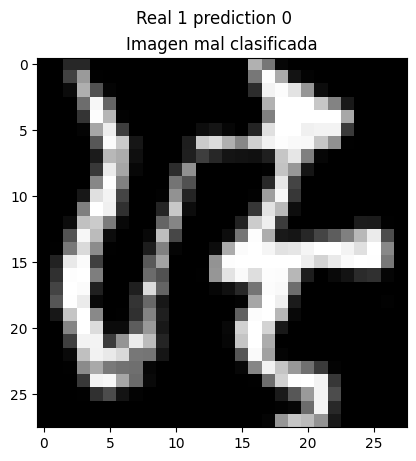

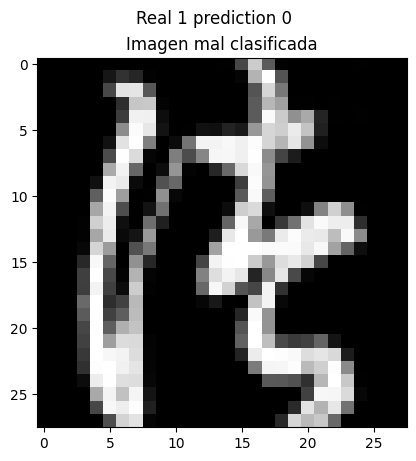

In [32]:
false_positive = np.where((y_labels != svm_lbpu_predictions) & (y_labels == 1))[0]

for index in false_positive[0:2]:
    plt.figure()
    plt.title(f"Imagen mal clasificada")
    plt.suptitle(f"Real {y_labels[index]} prediction {svm_lbpu_predictions[index]}")
    plt.imshow(y_images[index],cmap='gray')


## OBJECT RECOGNITION

### **Evaluación mediante test**


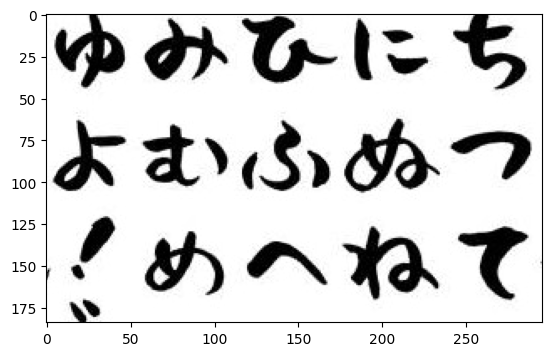

In [33]:
last_challenge_img = cv2.imread("kmnist\\kmnist_find_tsu.jpg")
last_challenge_img_gray = cv2.cvtColor(last_challenge_img, cv2.COLOR_BGR2GRAY)
plt.imshow(last_challenge_img_gray, cmap='gray')

Escala 0: (184, 296)
Escala 1: (146, 236)
Escala 2: (116, 188)
Escala 3: (92, 150)
Escala 4: (73, 120)


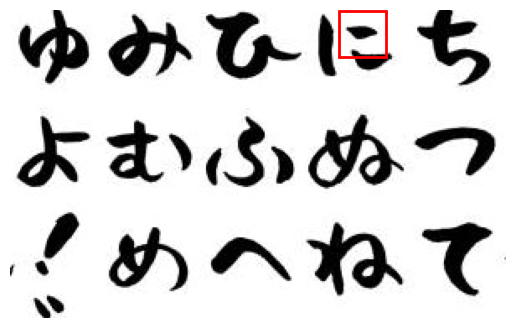

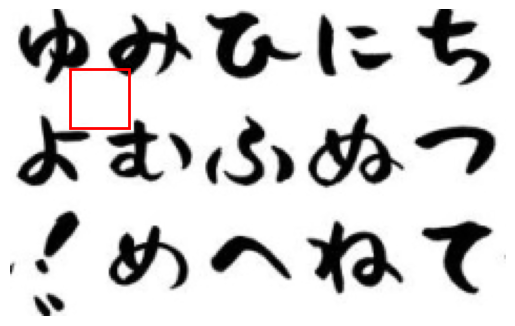

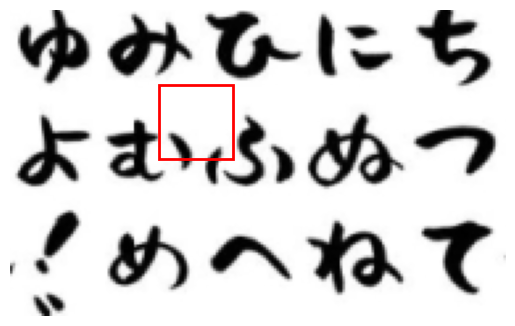

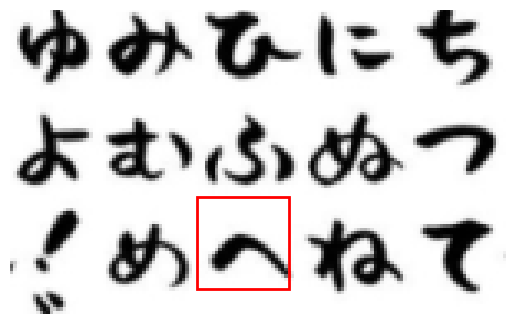

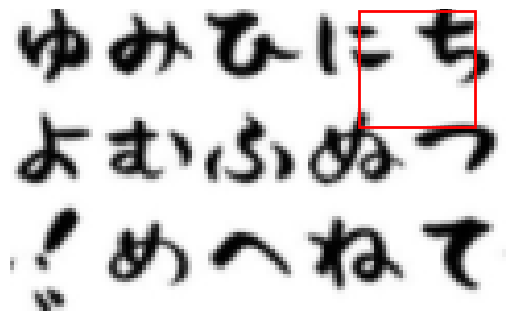

In [35]:
for i, layer in enumerate(pyramid(last_challenge_img_gray, scale=1.25, minSize=(60, 60))):
    print(f"Escala {i}: {layer.shape}")  
    window, result, img_best_result_frame = extract_better_result(layer, svm_clf_lbpu, lbpu)
    print_with_margin(layer, img_best_result_frame)
    